<div style="padding:20px;color:white;margin:0;font-size:300%;text-align:center;display:fill;border-radius:5px;background-color:#016CC9;overflow:hidden;font-weight:300"> Evaluation Pipeline </div>

<font size="4"> The notebook introduces the overview of the workflow for our system to detect the potholes by using both 2D and 3D detection models. For production of our system, it is expected that set up the computing server and implement backend engineering work by referencing this notebook. </font>

In [1]:
# import packages
import pandas as pd
import random
import os
import warnings
import random
import string
import cv2
warnings.filterwarnings('ignore')
random.seed(42)
import torch
import numpy as np
import shutil

# <b><span style='color:#4B4B4B'></span><span style='color:#016CC9'> Folders Setting </span></b>


In [2]:
# project name is defined by the upload video name and random id string

# project_name = 'scene1_e8Phytelu4' # scene2_AoU1tunj2p
project_name = 'scene2_AoU1tunj2p'
uploaded_files_dir = './uploaded_files/'  + project_name
twoD_detection_dir = './twoD_detection/' + project_name
threeD_reconstruction_dir = './threeD_reconstruction/' + project_name
potholes_evaluation_dir = './potholes_evaluation/' + project_name
road_evaluation_dir = './road_evaluation/' + project_name

In [3]:
# parameters setting
original_img_shape = {
    'width':1920,
    'height':1080
}
image_type = '.png'

# <b><span style='color:#4B4B4B'></span><span style='color:#016CC9'> Read 2D detection Results </span></b>

In [4]:
# define 2D detection dir here
results_dir = os.path.join(twoD_detection_dir, 'results', 'labels')

In [5]:
# more classified 
def potholes_classification (crop_image):
    types = [1 , 2,  3]
    image_type = random.choice(types)
    return image_type

In [6]:
data_per_frame = {
    'frame_id':[],
    'potholes_number':[],
    'average_score':[],
    'bbox_area':[],
    'average_confidence':[],
}

detection = {
    'frame_id':[],
    'pothole_id':[],
    'category':[],
    'xmin':[],
    'xmax':[],
    'ymin':[],
    'ymax':[],
    'conf':[]
}


def process_label_coordinates(data):
    x_center = original_img_shape['width']*data[1]

    y_center = original_img_shape['height']*data[2]
    width = original_img_shape['width']*data[3]
    height = original_img_shape['height']*data[4]

    xmin = int(x_center - width/2) 
    ymin = int(y_center - height/2)
    xmax = int(x_center + width/2) 
    ymax = int(y_center + height/2)
    
    area = width*height
    
    return xmin, ymin, xmax, ymax, area
    
hole_id = 0
for r_file in os.listdir(results_dir):
    file_path = os.path.join(results_dir, r_file)
    with open(file_path) as f: 
        lines = f.readlines()
        
        data_per_frame['frame_id'].append(r_file.split('.')[0])
        data_per_frame['potholes_number'].append(len(lines))
        
        all_area = 0
        conf_score = 0
        all_score = 0
        for l in lines:
            data = [float(num.strip('\n'))  for num in l.split(' ')]
            
            xmin, ymin, xmax, ymax, area = process_label_coordinates(data)
            
            # potholes type classfication
            crop_image = None
            pothole_type = potholes_classification (crop_image) # random assign potholes type
            
            # summarise into a dataframe
            detection['pothole_id'].append(str(hole_id))
            detection['frame_id'].append(r_file.split('.')[0])
            detection['category'].append(pothole_type)
            detection['xmin'].append(xmin)
            detection['ymin'].append(ymin)
            detection['xmax'].append(xmax)
            detection['ymax'].append(ymax)
            detection['conf'].append(data[-1])
            
            # process per frame information
            all_area += area
            conf_score += data[-1]
            all_score += pothole_type
            
            hole_id+=1
            
        data_per_frame['average_score'].append(all_score/len(lines))
        data_per_frame['bbox_area'].append(all_area)
        data_per_frame['average_confidence'].append(conf_score/len(lines))
        

In [7]:
detection_df = pd.DataFrame(detection)
detection_df = detection_df.sort_values(by=['frame_id'])
detection_df

,frame_id,pothole_id,category,xmin,xmax,ymin,ymax,conf
78,0001,78,3,603,946,609,881,0.869278
77,0001,77,2,1233,1414,397,533,0.391231
101,0002,101,3,574,933,635,926,0.712505
100,0002,100,3,747,959,508,678,0.440183
102,0002,102,3,1236,1425,398,540,0.747770
...,...,...,...,...,...,...,...,...
4,0173,4,2,499,793,413,589,0.875797
3,0173,3,3,14,648,834,1080,0.861330
2,0173,2,1,1119,1413,383,573,0.844694
1,0173,1,1,34,265,516,692,0.708766


In [8]:
data_per_frame_df = pd.DataFrame(data_per_frame)
data_per_frame_df = data_per_frame_df.sort_values(by=['frame_id'])
data_per_frame_df

,frame_id,potholes_number,average_score,bbox_area,average_confidence
23,0001,2,2.500000,117912.147696,0.630254
30,0002,3,3.000000,167011.217720,0.633486
33,0003,3,2.333333,222993.003264,0.481121
13,0004,2,1.000000,125840.147944,0.666135
14,0005,3,1.333333,99154.247936,0.538299
...,...,...,...,...,...
162,0169,4,1.250000,324036.975680,0.740118
10,0170,4,2.000000,183306.833240,0.707187
17,0171,3,2.000000,153154.392440,0.742629
7,0172,3,2.333333,184417.160720,0.683713


# <b><span style='color:#4B4B4B'></span><span style='color:#016CC9'>Crop Pothole Images for Fine Grained Classification</span></b>

In [9]:
# crop pothole images from 2d detection results
potholes_evaluation_dir_imgs = os.path.join(potholes_evaluation_dir, 'imgs')
if len(os.listdir(potholes_evaluation_dir_imgs))==0:
    for _, row in detection_df.iterrows():
        frame_id, pothole_id, xmin, xmax, ymin, ymax = row['frame_id'],  row['pothole_id'], row['xmin'], row['xmax'], row['ymin'], row['ymax']
        img_file = os.path.join(uploaded_files_dir, frame_id + image_type)
        img = cv2.imread(img_file)
        crop_img = img[ymin:ymax, xmin:xmax]
        write_img_path = os.path.join(potholes_evaluation_dir_imgs,pothole_id + image_type)
        cv2.imwrite(write_img_path, crop_img)

# <b><span style='color:#4B4B4B'></span><span style='color:#016CC9'> Read Potholes Evaluation</span></b>

In [10]:
# mapping classification to database
potholes_evaluation_dir_results = os.path.join(potholes_evaluation_dir, 'results')
portholes_evaluation_csv = os.path.join(potholes_evaluation_dir_results, 'results.csv')
portholes_evaluation_df = pd.read_csv(portholes_evaluation_csv)
portholes_evaluation_df['pothole_id'] = portholes_evaluation_df['image'].str.strip('.png')
di = {"mild":1, "moderate":2, 'severe':3}

portholes_evaluation_df['category'] = portholes_evaluation_df['type'].map(di)
portholes_evaluation_df

,image,type,pothole_id,category
0,348.png,severe,348,3
1,412.png,moderate,412,2
2,374.png,mild,374,1
3,360.png,mild,360,1
4,406.png,moderate,406,2
...,...,...,...,...
495,397.png,severe,397,3
496,340.png,moderate,340,2
497,426.png,moderate,426,2
498,432.png,severe,432,3


In [11]:
portholes_evaluation_df.groupby('type').count()

,image,pothole_id,category
type,,,
mild,140,140,140
moderate,262,262,262
severe,98,98,98


In [11]:
# replace the random assign categroical value
detection_df.merge(portholes_evaluation_df[['pothole_id', 'category']])
detection_df

,frame_id,pothole_id,category,xmin,xmax,ymin,ymax,conf
163,0001,163,3,609,897,396,555,0.872961
162,0001,162,3,767,928,349,459,0.806871
161,0001,161,1,897,1078,361,476,0.753034
160,0001,160,3,1489,1758,434,610,0.653953
159,0001,159,3,1251,1513,386,502,0.512644
...,...,...,...,...,...,...,...,...
926,0344,926,2,1275,1647,531,736,0.804801
920,0344,920,3,747,905,371,458,0.355251
919,0344,919,3,543,791,475,672,0.276037
922,0344,922,2,571,799,370,486,0.434003


# <b><span style='color:#4B4B4B'></span><span style='color:#016CC9'>Frame Localisation from 3D models</span></b>

In [12]:
# load the pose information to compute distance
pose_dir = os.path.join(threeD_reconstruction_dir, 'results', 'pose_data')
pose_x_file = os.path.join(pose_dir, 'pose_x.txt')
pose_z_file = os.path.join(pose_dir, 'pose_z.txt')

pose_data = {
    'frame_id':['0001', ],
    'x':[0],
    'z':[0]
}
with open(pose_x_file) as f:
    lines = f.readlines()
    for idx, l in enumerate(lines):
        pose_data['frame_id'].append(str(idx+2).zfill(4))
        pose_data['x'].append(float(l))
        
with open(pose_z_file) as f:
    lines = f.readlines()
    for l in lines:
        pose_data['z'].append(float(l))

pose_data_df = pd.DataFrame(pose_data)
pose_data_df 

,frame_id,x,z
0,0001,0.000000,0.000000
1,0002,0.002616,-0.211839
2,0003,0.007136,-0.520901
3,0004,0.013449,-0.829878
4,0005,0.021558,-1.100674
...,...,...,...
339,0340,-10.351153,-94.191444
340,0341,-10.313192,-94.455490
341,0342,-10.307578,-94.723022
342,0343,-10.275625,-95.011337


In [13]:
pose_data_df['dist'] = (pose_data_df['x'].pow(2) + pose_data_df['z'].pow(2)).pow(1./2)
pose_data_df

,frame_id,x,z,dist
0,0001,0.000000,0.000000,0.000000
1,0002,0.002616,-0.211839,0.211855
2,0003,0.007136,-0.520901,0.520950
3,0004,0.013449,-0.829878,0.829987
4,0005,0.021558,-1.100674,1.100885
...,...,...,...,...
339,0340,-10.351153,-94.191444,94.758507
340,0341,-10.313192,-94.455490,95.016849
341,0342,-10.307578,-94.723022,95.282197
342,0343,-10.275625,-95.011337,95.565384


In [14]:
frames_loc = {
    'start_id' : [],
    'end_id':[]
}
s_id = 0
e_id = 0
m = 1
for idx, row in pose_data_df.iterrows():
    if row['dist'] >= 10*m:
        e_id = idx
        frames_loc['start_id'].append(s_id)
        frames_loc['end_id'].append(e_id)
        s_id = e_id + 1
        m = m +1
        
# deal with final segment
if frames_loc['end_id'][-1]< len(pose_data_df['frame_id']) + 1:
    frames_loc['start_id'].append (frames_loc['end_id'][-1] + 1)
    frames_loc['end_id'].append (len(pose_data_df['frame_id']) + 1)

frames_loc_df = pd.DataFrame(frames_loc)
frames_loc_df.index.name = 'segment_id'
frames_loc_df = frames_loc_df.reset_index()
frames_loc_df

,segment_id,start_id,end_id
0,0,0,34
1,1,35,70
2,2,71,105
3,3,106,141
4,4,142,179
5,5,180,218
6,6,219,254
7,7,255,289
8,8,290,323
9,9,324,345


# <b><span style='color:#4B4B4B'></span><span style='color:#016CC9'> Representative Frames Samping </span></b>

In [15]:
data_per_frame_df = data_per_frame_df.apply(pd.to_numeric)

rep_frames =  {
    'segment_id':[],
    'start_id':[],
    'end_id':[],
    'rep_ids':[]
}
for index, row in frames_loc_df.iterrows():
    segment_id = row['segment_id']
    start_id = row['start_id']
    end_id = row['end_id']
    selected_df = data_per_frame_df[(data_per_frame_df['frame_id']>=start_id) & (data_per_frame_df['frame_id']<=end_id)]
    
    rep_ids = []
    for k in ['potholes_number', 'average_score', 'bbox_area', 'average_confidence']:
        max_df =   selected_df[selected_df[k] == max(selected_df[k])]
        for f_id in max_df['frame_id']:
            rep_ids.append(f_id)
    
    rep_ids = list(set(rep_ids))
    rep_frames['segment_id'].append(segment_id)
    rep_frames['start_id'].append(start_id)
    rep_frames['end_id'].append(end_id)
    rep_frames['rep_ids'].append(rep_ids)
    
rep_frames_df = pd.DataFrame(rep_frames)
rep_frames_df

,segment_id,start_id,end_id,rep_ids
0,0,0,34,"[16, 25, 10, 20]"
1,1,35,70,"[66, 35, 40, 44, 46, 48, 62]"
2,2,71,105,"[80, 74, 88]"
3,3,106,141,"[130, 135, 137, 106, 113, 118, 119, 121, 123]"
4,4,142,179,"[169, 173, 143, 144, 152]"
5,5,180,218,"[194, 211, 216, 218, 189]"
6,6,219,254,"[224, 232, 234, 247, 219, 252, 222, 223]"
7,7,255,289,"[261, 264, 277, 286, 287]"
8,8,290,323,"[320, 321, 323, 296, 300, 302, 308, 309, 312]"
9,9,324,345,"[328, 344, 342]"


# <b><span style='color:#4B4B4B'></span><span style='color:#016CC9'> Potholes Physical Properties </span></b>

In [16]:
# load the depth map
def load_depth_data(frame_id):
    # frame_id: str
    # return detpth data
    depth_dir = os.path.join(threeD_reconstruction_dir, 'results', 'depth_data')
    for file_name in os.listdir(depth_dir):
        file_path = os.path.join(depth_dir,file_name)
        depth_data = torch.load(file_path)
    return depth_data

In [17]:
# get depth map from 3D model and translate the image coordinates in to physical coodinates
# camera parameters
CAM_WID, CAM_HGT = 1920, 1080
CAM_FX, CAM_FY = 795.209, 793.957
CAM_CX, CAM_CY = 332.031, 231.308
    
def translate_img_world(img_x, img_y, img_z):
    # normalize
    x = img_x - CAM_CX
    y = img_y - CAM_CY
    
    real_x, real_y = img_z * x / CAM_FX, img_z * y / CAM_FX
    
    return real_x, real_y

def map2d_to_3d (frame_id, xmin, xmax, ymin, ymax):
    
    if xmax==CAM_WID: xmax-=1
    if ymax==CAM_HGT: ymax-=1
    
    frame_id_name = str(frame_id).zfill(4)
    depth_data = load_depth_data(frame_id)

    z_top = float(depth_data[ymin,xmin])
    z_bottom = float(depth_data[ymax,xmax])
    
    real_x_top, real_y_top = translate_img_world(xmin, ymin, z_top)
    real_x_bottom, real_y_bottom = translate_img_world(xmax, ymax, z_bottom)
    
    width = abs(real_x_top - real_x_bottom)
    height = abs(real_y_top - real_y_bottom)
    
    max_img_z = float(torch.max(depth_data[ymin:ymax,xmin:xmax]))
    
    return width, height, max_img_z


In [18]:
def adjust_length_cm(di, input_type='depth'):
    di_adjust = di
    if input_type=='depth':
        while di_adjust>=10:
            di_adjust*=0.1
                
        while di_adjust<1:
            di_adjust*=10
    else:
        while di_adjust<=10:
            di_adjust*=10
            
    if di_adjust>=5 and input_type=='depth':
        di_adjust*=0.5
                
    return di_adjust
    

In [19]:
detection_df['frame_id'] = pd.to_numeric(detection_df['frame_id'])

potholes_physical = {
    'segment_id':[],
    'frame_id':[],
    'pothole_type':[],
    'depth':[],
    'width':[],
    'height':[],

    'xmin':[],
    'xmax':[],
    'ymin':[],
    'ymax':[],
}

for _, row in rep_frames_df.iterrows():
    rep_ids = row['rep_ids']
    segment_id = row['segment_id']
    
    for rep_id in rep_ids:
        potholes_df = detection_df[detection_df['frame_id']==rep_id]
        
        for _, pothole in potholes_df.iterrows():
            frame_id = int(pothole['frame_id'])
            pothole_type = int(pothole['category'])
            xmin, xmax, ymin, ymax = pothole['xmin'], pothole['xmax'], pothole['ymin'], pothole['ymax']
            
            width, height, depth = map2d_to_3d (frame_id, xmin, xmax, ymin, ymax)
            width = adjust_length_cm(width, input_type='width')
            height = adjust_length_cm(height, input_type='height')
            depth = adjust_length_cm(depth, input_type='depth')
            
            # append data
            potholes_physical['segment_id'].append(segment_id)
            potholes_physical['frame_id'].append(frame_id)
            potholes_physical['pothole_type'].append(pothole_type)
            potholes_physical['depth'].append(depth)
            potholes_physical['height'].append(height)
            potholes_physical['width'].append(width)
            
            potholes_physical['xmin'].append(xmin)
            potholes_physical['xmax'].append(xmax)
            potholes_physical['ymin'].append(ymin)
            potholes_physical['ymax'].append(ymax)

potholes_physical_df = pd.DataFrame(potholes_physical)
potholes_physical_df

,segment_id,frame_id,pothole_type,depth,width,height,xmin,xmax,ymin,ymax
0,0,16,3,2.609863,22.914692,79.096518,0,491,453,835
1,0,16,3,4.423828,35.578034,20.864333,1295,1908,572,900
2,0,16,2,3.352051,99.239107,31.074011,0,206,698,1080
3,0,16,1,3.295898,27.991502,86.760744,85,720,422,743
4,0,16,3,2.731934,84.664998,96.658797,1196,1854,826,1079
...,...,...,...,...,...,...,...,...,...,...
206,9,342,3,4.963379,18.676406,61.567541,852,976,368,464
207,9,342,2,4.916992,74.130282,11.179065,580,780,369,491
208,9,342,1,3.779297,13.827151,13.849989,972,1170,393,530
209,9,342,3,2.565918,34.028035,43.377574,1180,1471,474,648


# <b><span style='color:#4B4B4B'></span><span style='color:#016CC9'> Road Segments Evaluation </span></b>

In [20]:
# evaluate single pothole
road_segments = {
    'segment_id':[],
    'segment_score':[],
    'highest_scoring_frame_id':[],
    'highest_scoring_frame_score':[]
}
for segment_id in potholes_physical_df['segment_id'].unique():
    segment_df = potholes_physical_df[potholes_physical_df['segment_id']==segment_id]
    
    for k in ['width', 'height', 'depth']:
        segment_df[k] = (segment_df[k]-min(segment_df[k]))/(max(segment_df[k]) - min(segment_df[k]))
    
    segment_df['score'] = segment_df['pothole_type'] + 3* segment_df['width']* segment_df['height']* segment_df['depth']
    
    scores = {}
    for frame_id in segment_df['frame_id'].unique():
        frame_segment = segment_df[segment_df['frame_id']==frame_id]
        scores[frame_id] = frame_segment['score'].sum()
    
    
    segment_score = segment_df['score'].sum()
    highest_scoring_frame_id = max(scores, key=scores.get)
    highest_scoring_frame_score = scores[highest_scoring_frame_id]
    
    # append data
    road_segments ['segment_id'].append(segment_id)
    road_segments ['segment_score'].append(segment_score)
    road_segments ['highest_scoring_frame_id'].append(highest_scoring_frame_id)
    road_segments ['highest_scoring_frame_score'].append(highest_scoring_frame_score)
    
road_segments_df = pd.DataFrame(road_segments)
road_segments_df

,segment_id,segment_score,highest_scoring_frame_id,highest_scoring_frame_score
0,0,59.991774,10,25.198107
1,1,40.164184,35,13.312865
2,2,31.680523,80,18.289298
3,3,46.513848,106,12.107276
4,4,29.048358,169,12.541844
5,5,53.146600,211,13.788023
6,6,85.501406,222,15.660071
7,7,45.500405,277,19.772838
8,8,71.115192,320,16.867806
9,9,57.046541,328,22.624043


# <b><span style='color:#4B4B4B'></span><span style='color:#016CC9'> Summarise Evaluation </span></b>

In [21]:
# Assume the street name is example
national_roads = {
    'street_name':[],
    'avg_score':[],
    'highest_score':[],
    'representative_frame_id':[],
    'most_serve_segment':[],
}
segment_id = road_segments_df.loc[road_segments_df['segment_score'].idxmax()]['segment_id']
national_roads['most_serve_segment'].append(segment_id)
national_roads['street_name'].append(project_name)
national_roads['avg_score'].append(road_segments_df['segment_score'].mean())
national_roads['highest_score'].append(road_segments_df['segment_score'].max())
national_roads['representative_frame_id'].append(road_segments_df.loc[road_segments_df['highest_scoring_frame_score'].idxmax()]['highest_scoring_frame_id'])
national_roads_df = pd.DataFrame(national_roads)
national_roads_df

,street_name,avg_score,highest_score,representative_frame_id,most_serve_segment
0,scene1_e8Phytelu4,51.970883,85.501406,10.0,6.0


In [22]:
# summairse important data table
summary_dir = os.path.join(road_evaluation_dir,'summary')
overall_csv =  os.path.join(summary_dir, 'overall_summary.csv')
road_segment_csv =  os.path.join(summary_dir, 'road_segment.csv')
potholes_csv =  os.path.join(summary_dir, 'potholes.csv')
frame_csv = os.path.join(summary_dir, 'frames.csv')

national_roads_df.to_csv(overall_csv)
road_segments_df.to_csv(road_segment_csv)
potholes_physical_df.to_csv(potholes_csv)
rep_frames_df.to_csv(frame_csv)

# <b><span style='color:#4B4B4B'></span><span style='color:#016CC9'> Visulize Evaluation </span></b>

In [23]:
for _, row in rep_frames_df.iterrows():
    segment_id = int(row['segment_id'])
    for r_id in row['rep_ids']:
        frame_file_name = str(r_id).zfill(4) + image_type
        # read oringinal file 
        img_path = os.path.join(uploaded_files_dir, frame_file_name)
        img_array = cv2.imread(img_path)
        potholes_single_df = potholes_physical_df[potholes_physical_df['frame_id']==r_id]
        for _, p in potholes_single_df.iterrows():
            # add box
            start_point = (int(p['xmin']), int(p['ymin']))
            end_point = (int(p['xmax']), int(p['ymax']))
            img_array = cv2.rectangle(img_array, start_point, end_point, (0, 0, 255), 2)
            # add text
            text = 't:{} d:{} '.format(int(p['pothole_type']), round(float(p['depth']),2)) 
            text1 = 'w:{} h:{}'.format(round(float(p['width']),2), round(float(p['height']),2))
            x0 = int(p['xmin']) 
            y0 = int(p['ymin']) + (int(p['ymax']) - int(p['ymin']))//3
            thick = int((img_array.shape[1] + img_array.shape[0]) // 900) 
            img_array = cv2.putText(img_array, text, (x0, y0 - 32), 0, 1.5e-3 * img_array.shape[0], (255,0,0), 2)
            img_array = cv2.putText(img_array, text1, (x0, y0 + 32), 0, 1.5e-3 * img_array.shape[0], (255,0,0), 2)

        vis_dir = os.path.join(road_evaluation_dir,'imgs','rep_frames', str(segment_id))
        if not os.path.exists(vis_dir): os.makedirs(vis_dir)
        output_path = os.path.join(vis_dir, frame_file_name)
        cv2.imwrite(output_path, img_array)
        
        severe_frame_id = int(national_roads_df['representative_frame_id'])
        if r_id == severe_frame_id:
            frame_file_name = str(severe_frame_id).zfill(4) + image_type
            vis_dir = os.path.join(road_evaluation_dir,'imgs','most_severe')
            if not os.path.exists(vis_dir): os.makedirs(vis_dir)
            dst = os.path.join(vis_dir,frame_file_name)
            shutil.copy(output_path, dst)

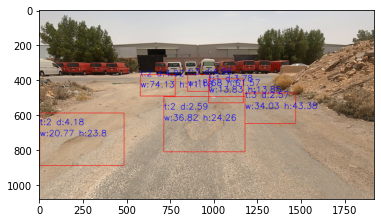

In [24]:
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
plt.show()